In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [2]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [3]:
def fn_generate_data(tau,N,p,p0,corr,conf,flagX):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1 
    
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    """
    tau = treatment effect
    Nrange - range of sample sizes
    p - number of covariates generated
    p0 - number of covariates included
    corr - correlation between covariates
    conf - confounder
    
    """
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)

## 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates. 

$y_i = \tau*T_i+\beta'*x_i+e_i$



# DAG

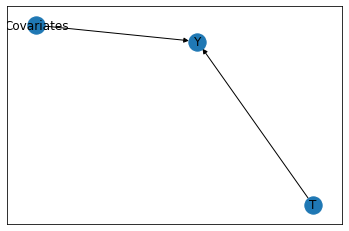

In [4]:
graph = nx.DiGraph()
g = nx.DiGraph()
g.add_edges_from([("T", "Y"), ("Covariates", "Y")])
plt.tight_layout()
nx.draw_networkx(g, arrows=True)
plt.show()

Real life example: T is studying time after midterm, Covariates is midterm test score, Y is Final grade. 
Study time after midterm has no effect on the midterm test score. It can only affect the final grade.
But current midterm score also has an effect on the final grade.

# Don't control any covariates

In [6]:
tau = 2
p = 100
p0 = 5 #number of covariates in the DGP
corr = 0.5 
conf = False
flagX = 1
N = 1000
Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)

In [8]:
data_Q1 = np.concatenate([Y,T,X[:,:p0]],axis = 1)
data_Q1 = pd.DataFrame(data_Q1)
data_Q1.columns = ['Y', 'T', 'X1', 'X2','X3','X4','X5']
data_Q1.to_csv('covariate.csv')
data_Q1

,Y,T,X1,X2,X3,X4,X5
0,37.748104,0.0,2.882779,0.217441,0.198710,-0.867386,0.935692
1,32.453212,0.0,2.493887,0.006288,0.942533,1.328584,0.961531
2,40.736218,1.0,0.233575,1.312633,1.262037,-0.123686,0.911846
3,34.273447,0.0,1.975448,-0.460198,0.083334,-1.183814,1.573522
4,-6.550245,1.0,-0.213497,0.108321,-0.780966,0.756033,0.479664
...,...,...,...,...,...,...,...
995,-24.510644,1.0,-0.638829,-0.719743,-0.444101,-1.154700,-1.404316
996,-4.658177,1.0,-0.839824,0.602930,-0.372154,-0.486609,-0.462866
997,-14.098694,1.0,-0.270409,0.208288,-0.885696,0.747625,-0.111342
998,2.880160,1.0,-0.677937,-0.096468,-0.142975,-0.981693,0.335029


In [18]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 70.88it/s]


In [19]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.02009651909999741, RMSE=4.530320488163173, size=0.0575
N=1000: bias=0.025853844834638793, RMSE=1.3788278516301748, size=0.051


# FlagX = 2, Use some right and wrong covariates / do not control covariates

In [24]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 71.04it/s]


In [25]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0023642752703981786, RMSE=0.1449827804704249, size=0.0575
N=1000: bias=0.0012646262565597633, RMSE=0.04403307017156734, size=0.052


# 2. Simulate a DGP with a confounder (common cause)

$y_i = \tau*T_i+\beta'*x_i+e_i$

$T_i = \gamma*x_i$

where $x_i$ is the confounder

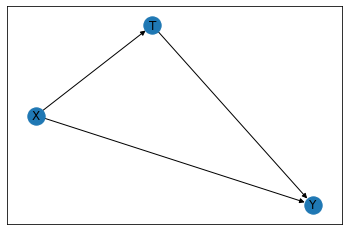

In [26]:
graph = nx.DiGraph()
g = nx.DiGraph()
g.add_edges_from([("T", "Y"), ("X", "Y"),("X","T")])
plt.tight_layout()
nx.draw_networkx(g, arrows=True)
plt.show()

Real world example: Beer consumption will cause overweight. And beer comsumption also has a negative effect on lack of exercise. Lack of exercise will cause overweight.

In [27]:
def fn_generate_data_conf(tau,N,p,p0,corr,conf = True):
    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1 
    nvar = p+1 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
    X = fn_generate_multnorm(N,corr,nvar)
    C = X[:,1].reshape([N,1]) # confounder
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    Yab = tau*T+0.5*C+err
    Tab = T+0.5*C
    

    return (Yab,Tab,C)

In [28]:
tau = 2
p = 100
p0 = 3 
corr = 0.5 
N = 1000
Nrange = range(10,1000,2)
conf = 1
Y,T,C = fn_generate_data_conf(tau,N,p,p0,corr,conf)

In [29]:
data_Q2 = np.concatenate([Y,T,C],axis = 1)
data_Q2 = pd.DataFrame(data_Q2)
data_Q2.columns = ["Y","Treatment","Confounder"]
data_Q2.to_csv("confounder.csv")
data_Q2

,Y,Treatment,Confounder
0,1.605513,0.120098,0.240197
1,-1.071646,0.054004,0.108007
2,-1.261118,-0.317969,-0.635938
3,0.848243,-0.180607,-0.361214
4,2.340992,0.461794,-1.076413
...,...,...,...
995,1.584503,0.789969,-0.420061
996,1.287226,0.822345,-0.355309
997,0.950811,1.043328,0.086655
998,0.353829,0.351704,0.703408


# a. You fail to control for the confounder

In [34]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,p0,corr,conf)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 61.72it/s]


In [36]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.003183062933376562, RMSE=0.1410370335237778, size=0.051
N=1000: bias=0.0004362660357177932, RMSE=0.04489964863900364, size=0.0545


# B. You control the confounder

In [35]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,p0,corr,conf)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:26<00:00, 75.56it/s]


In [37]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.003183062933376562, RMSE=0.1410370335237778, size=0.051
N=1000: bias=0.0004362660357177932, RMSE=0.04489964863900364, size=0.0545


# 3.Simulate a DGP with selection bias into the treatment

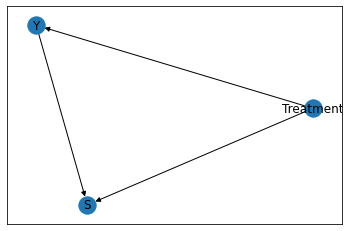

In [38]:
graph = nx.DiGraph()
g = nx.DiGraph()
g.add_edges_from([("Treatment", "Y"), ("Y", "S"),("Treatment","S")])
plt.tight_layout()
nx.draw_networkx(g, arrows=True)
plt.show()

$s = 0.6*y+0.5*T+u$,
    
$y = 2*T+e$,
   

Real example: Y is getting a job interview. Treatment is if the person has professional skills. S is whether the person is hired.  

In [39]:
def fn_generate_data_s(tau,N,p,corr):

    nvar = p+1 # 1 for selection bias
    corr = 0.5 # correlation for multivariate normal
 
    allX = fn_generate_multnorm(N,corr,nvar)
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    U = np.random.normal(0,1,[N,1])
    Y = tau*T+err
    S = 0.6*T+0.5*Y+U

    return (Y,T,S)

In [46]:
tau = 2
corr = 0.5
p = 3
N = 1000
Y,T,S = fn_generate_data_s(tau,N,p,corr)

data_Q3 = np.concatenate([Y,T,S],axis = 1)
data_Q3 = pd.DataFrame(data_Q3)
data_Q3.columns = ['Y', 'T', 'S']
data_Q3.to_csv('selectionbias.csv')
data_Q3

,Y,T,S
0,-0.487978,0.0,0.745297
1,2.453715,1.0,2.275270
2,3.301882,1.0,3.086733
3,2.410699,1.0,4.541856
4,1.814677,1.0,2.172228
...,...,...,...
995,-0.184840,1.0,0.067676
996,-1.045244,0.0,-0.517712
997,-2.078126,0.0,-1.852930
998,1.928195,1.0,1.293003


# A. Do not control for selection bias


In [47]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)   
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:12<00:00, 164.76it/s]


In [48]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0036427500147733338, RMSE=0.2008533171906668, size=0.0525
N=1000: bias=-0.0003259854128652543, RMSE=0.06414904046714491, size=0.054


# B. control for selection bias

In [49]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)
        covars = np.concatenate([T,Z],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:13<00:00, 148.85it/s]


In [50]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.6390968177416922, RMSE=0.6652901840602992, size=0.936
N=1000: bias=-0.6406790917724589, RMSE=0.6432159053261197, size=1.0
